# Mini-project2 - 더 깊은 Network를 위한 ResNet구현 및 학습

목표
1. VGG-19 구현 및 34-layer plain network 구현
2. residual block 을 이용한 ResNet 구현
3. VGG-19와 ResNet의 성능비교
4. Pre-activation 구현 및 성능비교

# 사용할 라이브러리 import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, AveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
#
# import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' ## 이거 안쓰면 GPU메모리 확 잡아먹어 알아서 GPU메모리 선점해
#

## 학습시키기 위해 메모리 분배

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))  ### GPU 메모리 소모량 감소 OOM발생해서 처리

# Dataset 준비

데이터셋은 cifar100을 이용할것이다.
총 class는 100개 이고 이미지 데이터니 255.0으로 나눠줘서 데이터 정규화 시키고 정답라벨인 Y에는 클래스명을 붙여주었고 train data(50000)를 train data(40000)과 validation data(10000)로 80:20비율로 분할하였다.  

In [3]:
num_classes = 100
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(40000, 100)
(10000, 32, 32, 3)
(10000, 100)
(10000, 32, 32, 3)
(10000, 100)


# VGG_19 모델링

In [4]:
VGG_19_model = Sequential()
VGG_19_model.add(InputLayer(input_shape=(32, 32, 3))) 

VGG_19_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

VGG_19_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

VGG_19_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))  
VGG_19_model.add(BatchNormalization())
VGG_19_model.add(MaxPool2D(pool_size=(2, 2), strides=2))


VGG_19_model.add(Flatten())
VGG_19_model.add(Dense(units=512, activation='relu'))
VGG_19_model.add(Dense(units=512, activation='relu'))
VGG_19_model.add(Dense(units=100, activation='softmax'))
VGG_19_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       5

## optimizer='sgd', loss=CategoricalCrossentropy, metrics=accuracy
옵티마이저는 SGD와 아래 ADAM을 비교해볼것이다. loss함수는 분류문제를 풀기때문에 CE를 사용하였고 정확도를 보기위해 metrics를 accuracy로 사용하였다.

In [5]:
VGG_19_model.compile(optimizer='sgd', 
              loss=CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [6]:
# VGG_19_model.compile(optimizer='adam',
#               loss=CategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

# 학습진행

In [7]:
print("Fit model on training data")
history_vgg = VGG_19_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val)
)

Fit model on training data
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 67s 2ms/sample - loss: 3.9745 - accuracy: 0.0952 - val_loss: 4.0496 - val_accuracy: 0.0922
Epoch 2/30
40000/40000 [==============================] - 69s 2ms/sample - loss: 3.3601 - accuracy: 0.1866 - val_loss: 3.2400 - val_accuracy: 0.2147
Epoch 3/30
40000/40000 [==============================] - 67s 2ms/sample - loss: 2.9314 - accuracy: 0.2642 - val_loss: 2.9385 - val_accuracy: 0.2669
Epoch 4/30
40000/40000 [==============================] - 70s 2ms/sample - loss: 2.5617 - accuracy: 0.3372 - val_loss: 2.5997 - val_accuracy: 0.3359
Epoch 5/30
40000/40000 [==============================] - 70s 2ms/sample - loss: 2.2363 - accuracy: 0.4032 - val_loss: 2.6999 - val_accuracy: 0.3352
Epoch 6/30
40000/40000 [==============================] - 70s 2ms/sample - loss: 1.9567 - accuracy: 0.4691 - val_loss: 2.5192 - val_accuracy: 0.3651
Epoch 7/30
40000/40000 [=====

# 학습과정 시각화

밑의 그림은 sgd를 이용한 학습결과이다. 20epochs를 돌린 그래프이다.

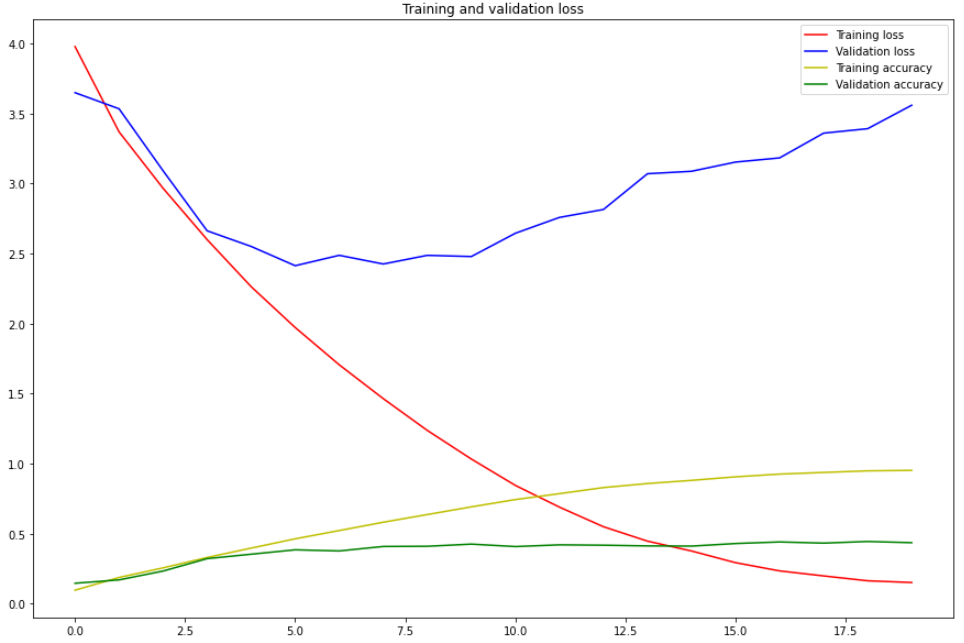

밑에 그림은 ADAM을 사용해서 20EPOCHS돌린 그림이다. SGD를 사용한게 성능이 더 좋으니 SGD를 사용하겠다. 

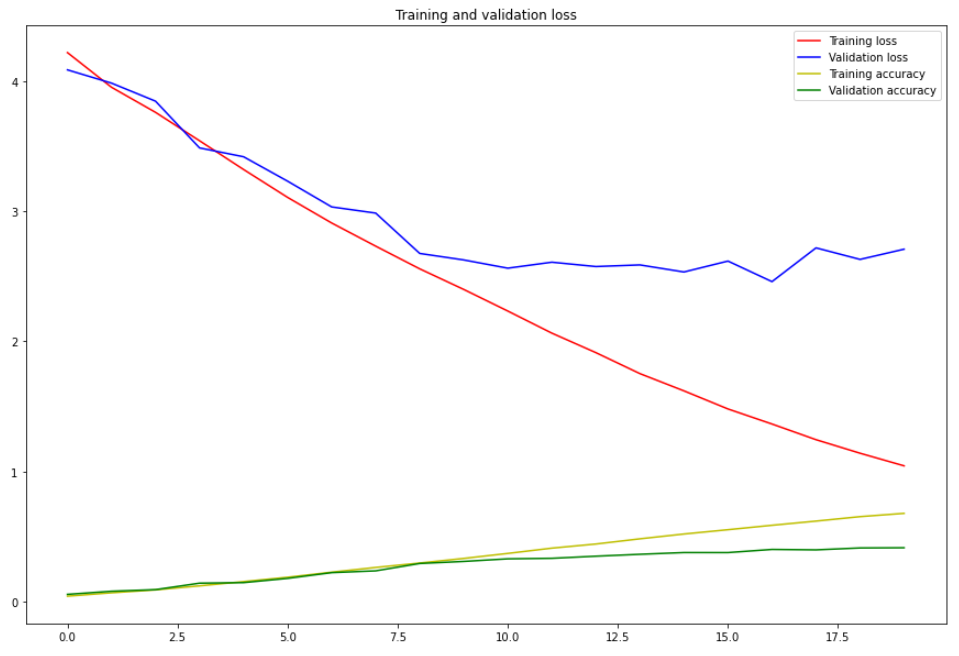

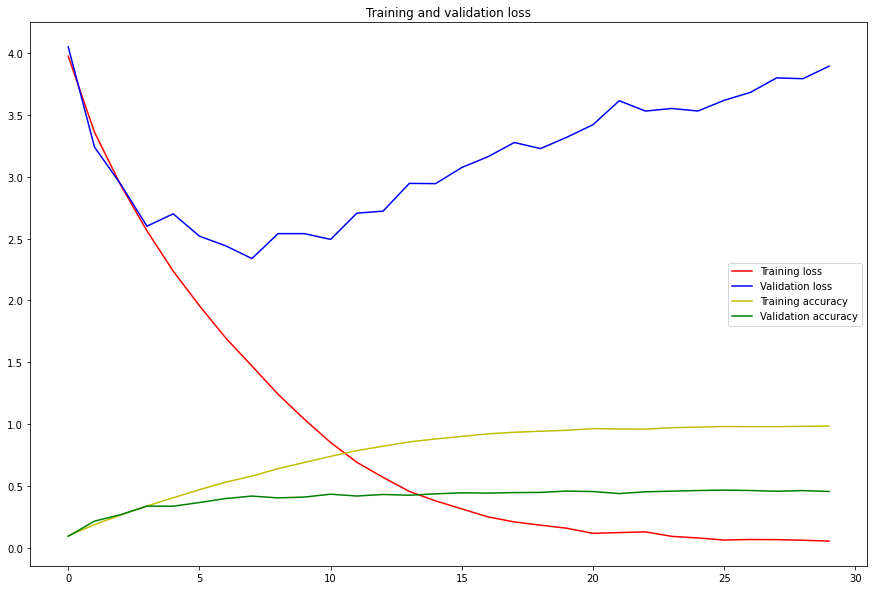

In [8]:
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
accuracy_vgg = history_vgg.history['accuracy']
val_accuracy_vgg = history_vgg.history['val_accuracy']

epochs = range(len(loss_vgg))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss_vgg, 'r', label='Training loss')
plt.plot(epochs, val_loss_vgg, 'b',label='Validation loss')
plt.plot(epochs, accuracy_vgg, 'y',label='Training accuracy')
plt.plot(epochs, val_accuracy_vgg, 'g',label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Test 결과

In [9]:
print("Fit model on test data")
test_loss_vgg, test_acc_vgg = VGG_19_model.evaluate(x_test, y_test, verbose=1)
print(test_acc_vgg)

Fit model on test data
10000/10000 [==============================] - 4s 406us/sample - loss: 3.8244 - accuracy: 0.4639
0.4639


- accuracy는 ADAM을 사용시 20epochs시 42%의 성능이 나온다.
- accuracy는 SGD를 사용시 20epochs시 46%의 성능이 나온다.
- accuracy는 SGD를 사용시 10epochs시 44%의 성능이 나온다.
- accuracy는 SGD를 사용시 30epochs시 46%의 성능이 나온다.

# 34-layer plain 구현 

ResNet논문은 ImageNet대회에서 나온 ILSVRC 2012 dataset을 사용하였다.
cifar100은 위의 데이터보다 훨씬 적은량의 데이터임으로 ResNet논문에 나온 34-layer plain구현과 동시에
cifar100의 데이터셋을 동작시키기위해 모델을 경량화 시켰다. 주석처리한것이 그것이다.

In [10]:
plain_34_layer_model = Sequential()
plain_34_layer_model.add(InputLayer(input_shape=(32, 32, 3))) 
plain_34_layer_model.add(Conv2D(filters=64, kernel_size=(7, 7), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=32, kernel_size=(7, 7), strides = 2, activation='relu', padding='same'))  
plain_34_layer_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

plain_34_layer_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
plain_34_layer_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
plain_34_layer_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
plain_34_layer_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))

plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))  
plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))

plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  
# plain_34_layer_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))

# plain_34_layer_model.add(Conv2D(filters=512, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
# plain_34_layer_model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
plain_34_layer_model.add(AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'))

plain_34_layer_model.add(Flatten())
plain_34_layer_model.add(Dense(units=100, activation='softmax'))
plain_34_layer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        9472      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 128)        

## optimizer='sgd', loss=CategoricalCrossentropy, metrics=accuracy
옵티마이저는 SGD와 아래 ADAM을 비교해볼것이다. loss함수는 분류문제를 풀기때문에 CE를 사용하였고 정확도를 보기위해 metrics를 accuracy로 사용하였다.

In [11]:
plain_34_layer_model.compile(optimizer='sgd', 
              loss=CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [12]:
# plain_34_layer_model.compile(optimizer='adam', 
#               loss=CategoricalCrossentropy(from_logits=False), 
#               metrics=['accuracy'])

In [13]:
print("Fit model on training data")
history_34 = plain_34_layer_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val)
)

Fit model on training data
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 18s 458us/sample - loss: 4.6053 - accuracy: 0.0091 - val_loss: 4.6054 - val_accuracy: 0.0088
Epoch 2/30
40000/40000 [==============================] - 17s 432us/sample - loss: 4.6051 - accuracy: 0.0105 - val_loss: 4.6055 - val_accuracy: 0.0083
Epoch 3/30
40000/40000 [==============================] - 16s 411us/sample - loss: 4.6047 - accuracy: 0.0103 - val_loss: 4.6052 - val_accuracy: 0.0083
Epoch 4/30
40000/40000 [==============================] - 16s 402us/sample - loss: 4.6030 - accuracy: 0.0156 - val_loss: 4.6010 - val_accuracy: 0.0147
Epoch 5/30
40000/40000 [==============================] - 17s 420us/sample - loss: 4.5191 - accuracy: 0.0201 - val_loss: 4.4155 - val_accuracy: 0.0305
Epoch 6/30
40000/40000 [==============================] - 16s 407us/sample - loss: 4.3416 - accuracy: 0.0406 - val_loss: 4.2628 - val_accuracy: 0.0509
Epoch 7/30
40000/

## 학습과정 시각화

밑의 그림은 sgd를 이용한 학습결과이다. 20epochs를 돌린 그래프이다.

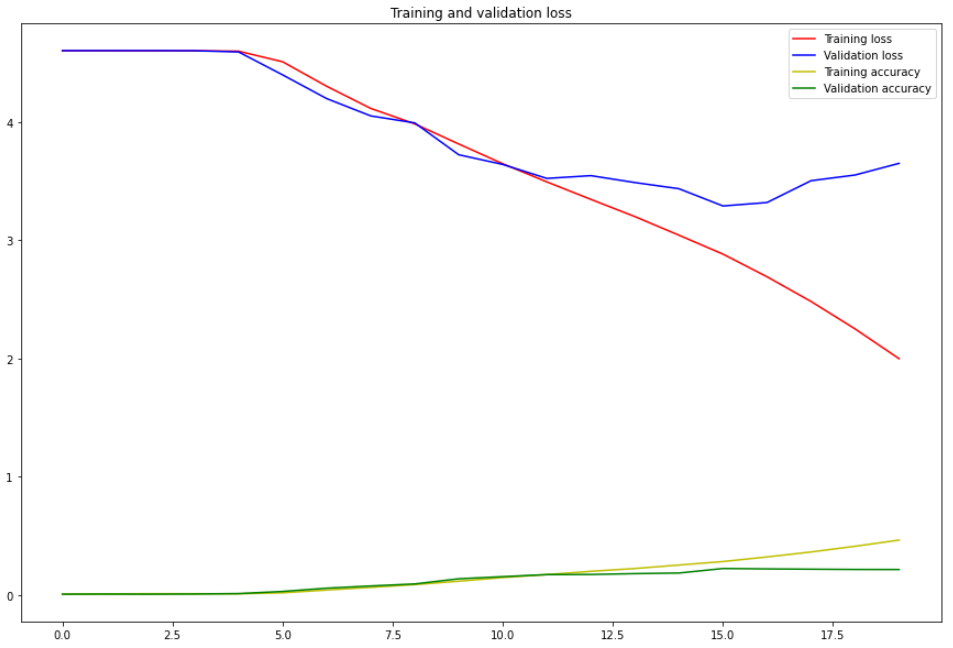

밑에 그림은 ADAM을 사용해서 20EPOCHS돌린 그림이다. 무엇이 문제인지 학습이 이루어지지 않고있다. 
SGD를 사용한게 성능이 더 좋으니 SGD를 사용하겠다. 

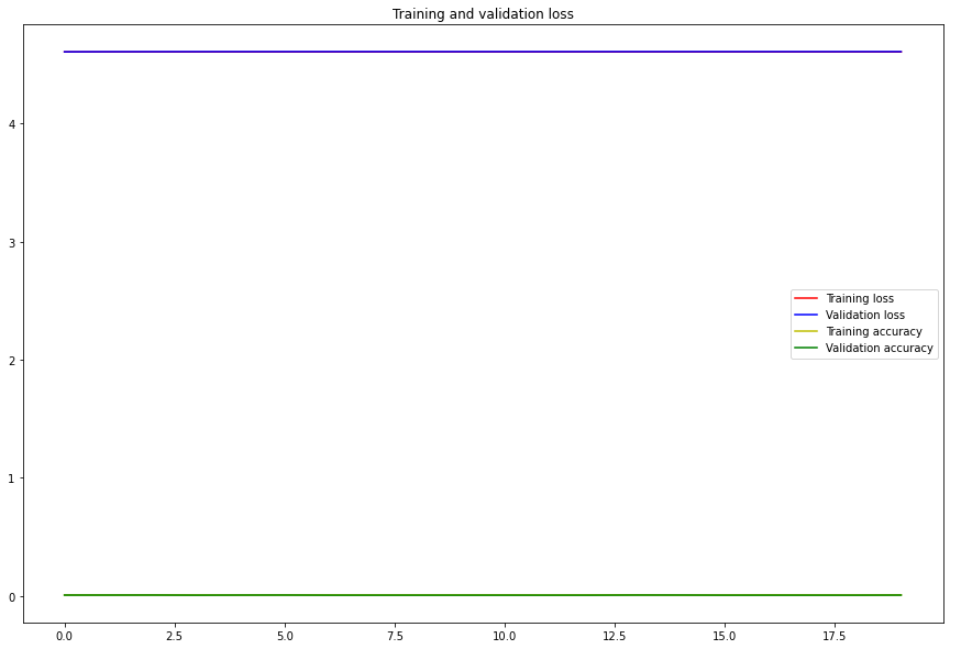

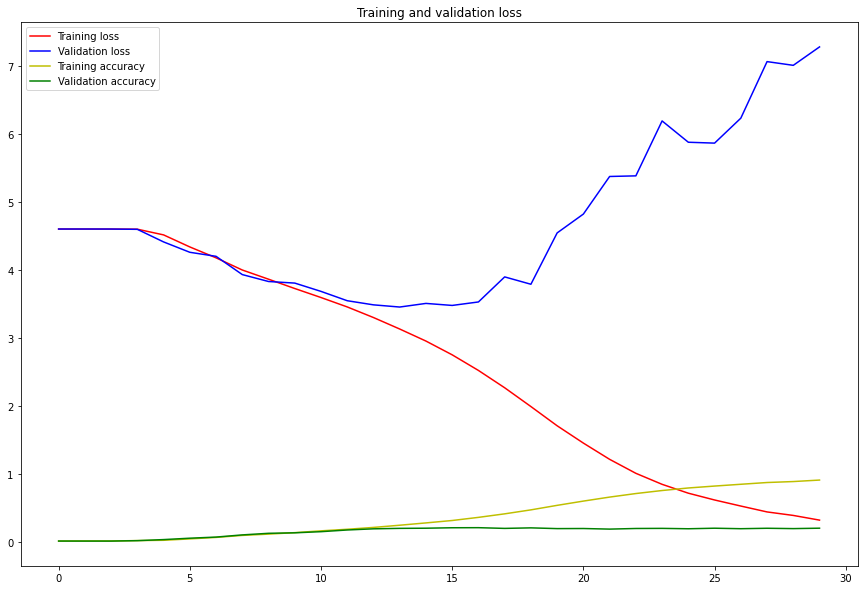

In [14]:
loss_34 = history_34.history['loss']
val_loss_34 = history_34.history['val_loss']
accuracy_34 = history_34.history['accuracy']
val_accuracy_34 = history_34.history['val_accuracy']

epochs = range(len(loss_34))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss_34, 'r', label='Training loss')
plt.plot(epochs, val_loss_34, 'b',label='Validation loss')
plt.plot(epochs, accuracy_34, 'y',label='Training accuracy')
plt.plot(epochs, val_accuracy_34, 'g',label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
print("Fit model on test data")
test_loss_34, test_acc_34 = plain_34_layer_model.evaluate(x_test, y_test, verbose=1)
print(test_acc_34)

Fit model on test data
10000/10000 [==============================] - 2s 163us/sample - loss: 7.2240 - accuracy: 0.2129
0.2129


- accuracy는 ADAM을 사용시 20epochs시 0.01%의 성능이 나온다.
- accuracy는 SGD를 사용시 20epochs시 22%의 성능이 나온다.
- accuracy는 SGD를 사용시 10epochs시 16%의 성능이 나온다.
- accuracy는 SGD를 사용시 30epochs시 21%의 성능이 나온다. 성능이 저하되었다.

# Resnet 구현

ResNet논문은 ImageNet대회에서 나온 ILSVRC 2012 dataset을 사용하였다.
cifar100은 위의 데이터보다 훨씬 적은량의 데이터임으로 ResNet논문에 나온 34-layer plain구현과 동시에
cifar100의 데이터셋을 동작시키기위해 모델을 경량화 시켰다. 주석처리한것이 그것이다.

In [16]:
class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.conv1(x)
        h = self.bn1(h, training=training)
        h = tf.nn.relu(h)
        
        
        h = self.conv2(h)
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        return self.identity(x) + h

In [17]:
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x

In [18]:
ResNet_model = Sequential()
ResNet_model.add(InputLayer(input_shape=(32, 32, 3))) 
ResNet_model.add(Conv2D(filters=32, kernel_size=(7, 7), activation='relu', padding='same'))  
# ResNet_model.add(Conv2D(filters=32, kernel_size=(7, 7), strides = 2, activation='relu', padding='same')) 
ResNet_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

ResNet_model.add(ResnetLayer(32, (64, 64), (3, 3)))
ResNet_model.add(ResnetLayer(32, (64, 64), (3, 3)))
# ResNet_model.add(ResnetLayer(32, (64, 64), (3, 3)))

ResNet_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
ResNet_model.add(ResnetLayer(64, (128, 128), (3, 3)))
ResNet_model.add(ResnetLayer(64, (128, 128), (3, 3)))
# ResNet_model.add(ResnetLayer(64, (128, 128), (3, 3)))
# ResNet_model.add(ResnetLayer(64, (128, 128), (3, 3)))

ResNet_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
ResNet_model.add(ResnetLayer(128, (256, 256), (3, 3)))
ResNet_model.add(ResnetLayer(128, (256, 256), (3, 3)))
# ResNet_model.add(ResnetLayer(128, (256, 256), (3, 3)))
# ResNet_model.add(ResnetLayer(128, (256, 256), (3, 3)))
# ResNet_model.add(ResnetLayer(128, (256, 256), (3, 3)))
# ResNet_model.add(ResnetLayer(128, (256, 256), (3, 3)))  


# ResNet_model.add(Conv2D(filters=256, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
# ResNet_model.add(ResnetLayer(256, (512, 512), (3, 3)))
# ResNet_model.add(ResnetLayer(256, (512, 512), (3, 3)))
# ResNet_model.add(ResnetLayer(256, (512, 512), (3, 3)))  

ResNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'))

ResNet_model.add(Flatten())
ResNet_model.add(Dense(units=100, activation='softmax'))
ResNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
resnet_layer (ResnetLayer)   (None, 16, 16, 64)        132416    
_________________________________________________________________
resnet_layer_1 (ResnetLayer) (None, 16, 16, 64)        152896    
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
resnet_layer_2 (ResnetLayer) (None, 8, 8, 128)         526976    
_________________________________________________________________
resnet_layer_3 (ResnetLayer) (None, 8, 8, 128)        

## optimizer='sgd', loss=CategoricalCrossentropy, metrics=accuracy
옵티마이저는 SGD와 아래 ADAM을 비교해볼것이다. loss함수는 분류문제를 풀기때문에 CE를 사용하였고 정확도를 보기위해 metrics를 accuracy로 사용하였다.

In [19]:
ResNet_model.compile(optimizer='sgd', 
              loss=CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [20]:
# ResNet_model.compile(optimizer='adam', 
#               loss=CategoricalCrossentropy(from_logits=False), 
#               metrics=['accuracy'])

In [21]:
print("Fit model on training data")
history_res = ResNet_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val)
)

Fit model on training data
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 42s 1ms/sample - loss: 3.9903 - accuracy: 0.1156 - val_loss: 3.5633 - val_accuracy: 0.1724
Epoch 2/30
40000/40000 [==============================] - 38s 961us/sample - loss: 3.1639 - accuracy: 0.2344 - val_loss: 3.2562 - val_accuracy: 0.2272
Epoch 3/30
40000/40000 [==============================] - 38s 959us/sample - loss: 2.7216 - accuracy: 0.3201 - val_loss: 3.1488 - val_accuracy: 0.2472
Epoch 4/30
40000/40000 [==============================] - 38s 960us/sample - loss: 2.3344 - accuracy: 0.4014 - val_loss: 2.9466 - val_accuracy: 0.2872
Epoch 5/30
40000/40000 [==============================] - 38s 960us/sample - loss: 1.9561 - accuracy: 0.4906 - val_loss: 2.9355 - val_accuracy: 0.3001
Epoch 6/30
40000/40000 [==============================] - 37s 934us/sample - loss: 1.5884 - accuracy: 0.5852 - val_loss: 2.8924 - val_accuracy: 0.3097
Epoch 7/30
40000/40

## 학습과정 시각화

밑의 그림은 sgd를 이용한 학습결과이다. 20epochs를 돌린 그래프이다.

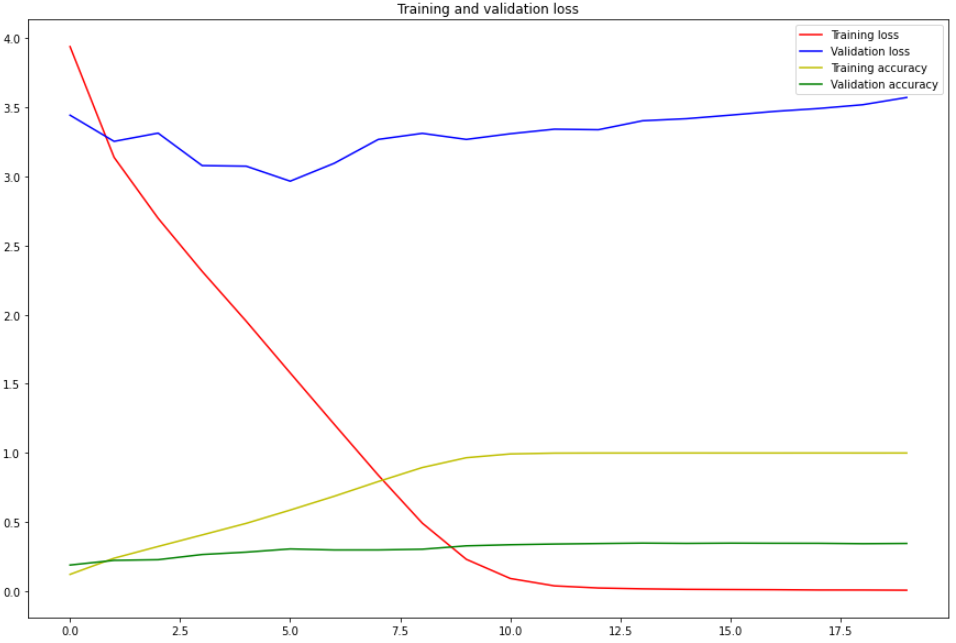

밑에 그림은 ADAM을 사용해서 20EPOCHS돌린 그림이다. 
SGD를 사용한게 성능이 더 좋으니 SGD를 사용하겠다.

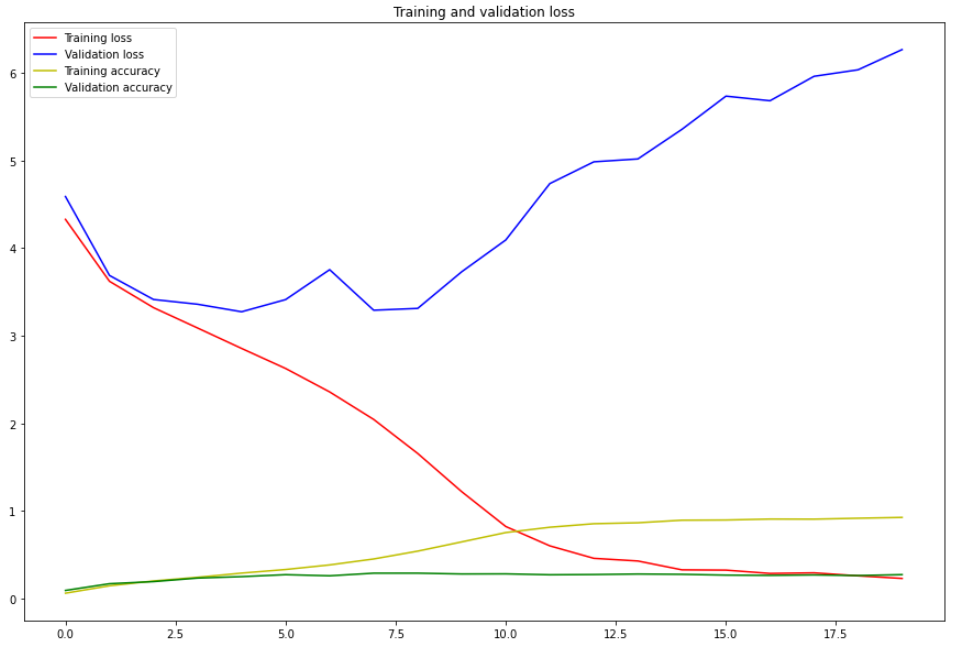

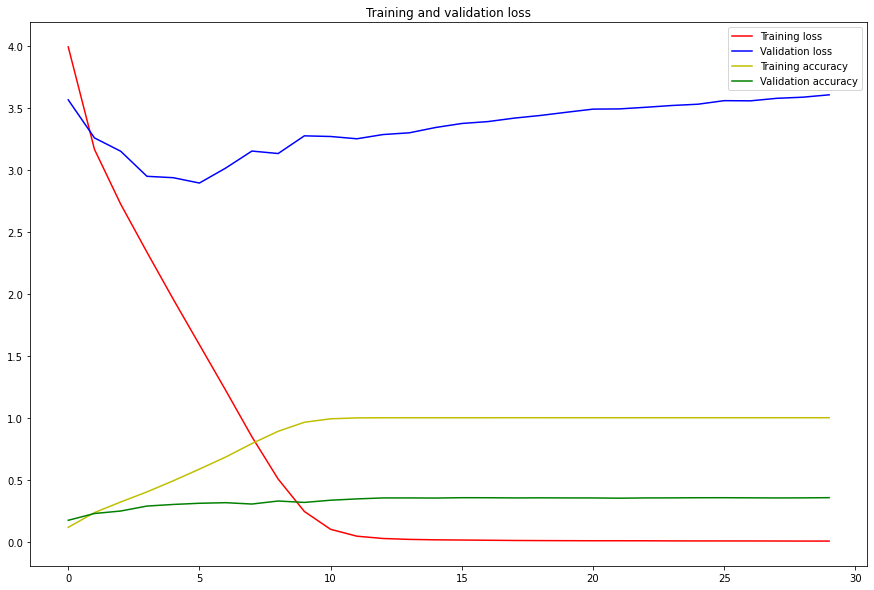

In [22]:
loss_res = history_res.history['loss']
val_loss_res = history_res.history['val_loss']
accuracy_res = history_res.history['accuracy']
val_accuracy_res = history_res.history['val_accuracy']

epochs = range(len(loss_res))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss_res, 'r', label='Training loss')
plt.plot(epochs, val_loss_res, 'b',label='Validation loss')
plt.plot(epochs, accuracy_res, 'y',label='Training accuracy')
plt.plot(epochs, val_accuracy_res, 'g',label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
print("Fit model on test data")
test_loss_res, test_acc_res = ResNet_model.evaluate(x_test, y_test, verbose=1)
print(test_acc_res)

Fit model on test data
10000/10000 [==============================] - 3s 303us/sample - loss: 3.5400 - accuracy: 0.3619 - loss: 3.5575 
0.3619


- accuracy는 ADAM을 사용시 20epochs시 28%의 성능이 나온다.
- accuracy는 SGD를 사용시 20epochs시 36%의 성능이 나온다.
- accuracy는 SGD를 사용시 10epochs시 34%의 성능이 나온다.
- accuracy는 SGD를 사용시 30epochs시 36%의 성능이 나온다.


# Use Preactivation

ResNet논문은 ImageNet대회에서 나온 ILSVRC 2012 dataset을 사용하였다.
cifar100은 위의 데이터보다 훨씬 적은량의 데이터임으로 ResNet논문에 나온 34-layer plain구현과 동시에
cifar100의 데이터셋을 동작시키기위해 모델을 경량화 시켰다. 주석처리한것이 그것이다.

In [24]:
class preResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(preResidualUnit, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = tf.keras.layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        return self.identity(x) + h

In [25]:
class preResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(preResnetLayer, self).__init__()
        self.sequence = list()
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(preResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x

In [26]:
preResnet_model = Sequential()
preResnet_model.add(InputLayer(input_shape=(32, 32, 3))) 
preResnet_model.add(Conv2D(filters=32, kernel_size=(7, 7), activation='relu', padding='same'))  
# preResnet_model.add(Conv2D(filters=32, kernel_size=(7, 7), strides = 2, activation='relu', padding='same')) 
preResnet_model.add(MaxPool2D(pool_size=(2, 2), strides=2))

preResnet_model.add(preResnetLayer(32, (64, 64), (3, 3)))
preResnet_model.add(preResnetLayer(32, (64, 64), (3, 3)))
# preResnet_model.add(preResnetLayer(32, (64, 64), (3, 3)))

preResnet_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
preResnet_model.add(preResnetLayer(64, (128, 128), (3, 3)))
preResnet_model.add(preResnetLayer(64, (128, 128), (3, 3)))
# preResnet_model.add(preResnetLayer(64, (128, 128), (3, 3)))
# preResnet_model.add(preResnetLayer(64, (128, 128), (3, 3)))

preResnet_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
preResnet_model.add(preResnetLayer(128, (256, 256), (3, 3)))
preResnet_model.add(preResnetLayer(128, (256, 256), (3, 3)))
# preResnet_model.add(preResnetLayer(128, (256, 256), (3, 3)))
# preResnet_model.add(preResnetLayer(128, (256, 256), (3, 3)))
# preResnet_model.add(preResnetLayer(128, (256, 256), (3, 3)))
# preResnet_model.add(preResnetLayer(128, (256, 256), (3, 3)))  


# preResnet_model.add(Conv2D(filters=256, kernel_size=(3, 3), strides = 2, activation='relu', padding='same'))
# preResnet_model.add(preResnetLayer(256, (512, 512), (3, 3)))
# preResnet_model.add(preResnetLayer(256, (512, 512), (3, 3)))
# preResnet_model.add(preResnetLayer(256, (512, 512), (3, 3)))  

preResnet_model.add(AveragePooling2D(pool_size=(2, 2), strides=2, padding='same'))

preResnet_model.add(Flatten())
preResnet_model.add(Dense(units=100, activation='softmax'))
preResnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
pre_resnet_layer (preResnetL (None, 16, 16, 64)        132288    
_________________________________________________________________
pre_resnet_layer_1 (preResne (None, 16, 16, 64)        152896    
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
pre_resnet_layer_2 (preResne (None, 8, 8, 128)         526720    
_________________________________________________________________
pre_resnet_layer_3 (preResne (None, 8, 8, 128)        

## optimizer='sgd', loss=CategoricalCrossentropy, metrics=accuracy
옵티마이저는 SGD와 아래 ADAM을 비교해볼것이다. loss함수는 분류문제를 풀기때문에 CE를 사용하였고 정확도를 보기위해 metrics를 accuracy로 사용하였다.

In [27]:
preResnet_model.compile(optimizer='sgd', 
              loss=CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [28]:
# preResnet_model.compile(optimizer='adam', 
#               loss=CategoricalCrossentropy(from_logits=False), 
#               metrics=['accuracy'])

In [29]:
print("Fit model on training data")
history_preres = preResnet_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val)
)

Fit model on training data
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 41s 1ms/sample - loss: 4.0745 - accuracy: 0.1065 - val_loss: 3.6510 - val_accuracy: 0.1516
Epoch 2/30
40000/40000 [==============================] - 38s 941us/sample - loss: 3.2513 - accuracy: 0.2189 - val_loss: 3.2729 - val_accuracy: 0.2254
Epoch 3/30
40000/40000 [==============================] - 38s 938us/sample - loss: 2.8126 - accuracy: 0.3015 - val_loss: 3.0832 - val_accuracy: 0.2576
Epoch 4/30
40000/40000 [==============================] - 33s 819us/sample - loss: 2.4586 - accuracy: 0.3742 - val_loss: 3.4115 - val_accuracy: 0.2211
Epoch 5/30
40000/40000 [==============================] - 30s 762us/sample - loss: 2.1279 - accuracy: 0.4470 - val_loss: 2.9359 - val_accuracy: 0.2965
Epoch 6/30
40000/40000 [==============================] - 30s 760us/sample - loss: 1.8038 - accuracy: 0.5253 - val_loss: 3.1065 - val_accuracy: 0.2884
Epoch 7/30
40000/40

## 학습과정 시각화

밑의 그림은 sgd를 이용한 학습결과이다. 20epochs를 돌린 그래프이다.

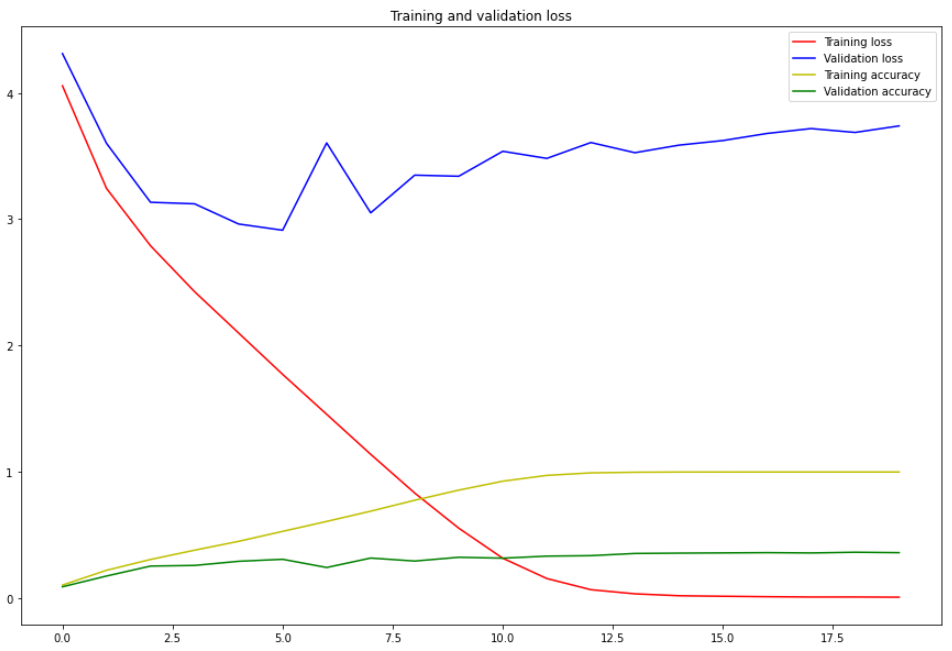

밑에 그림은 ADAM을 사용해서 20EPOCHS돌린 그림이다. 
SGD를 사용한게 성능이 더 좋으니 SGD를 사용하겠다. 

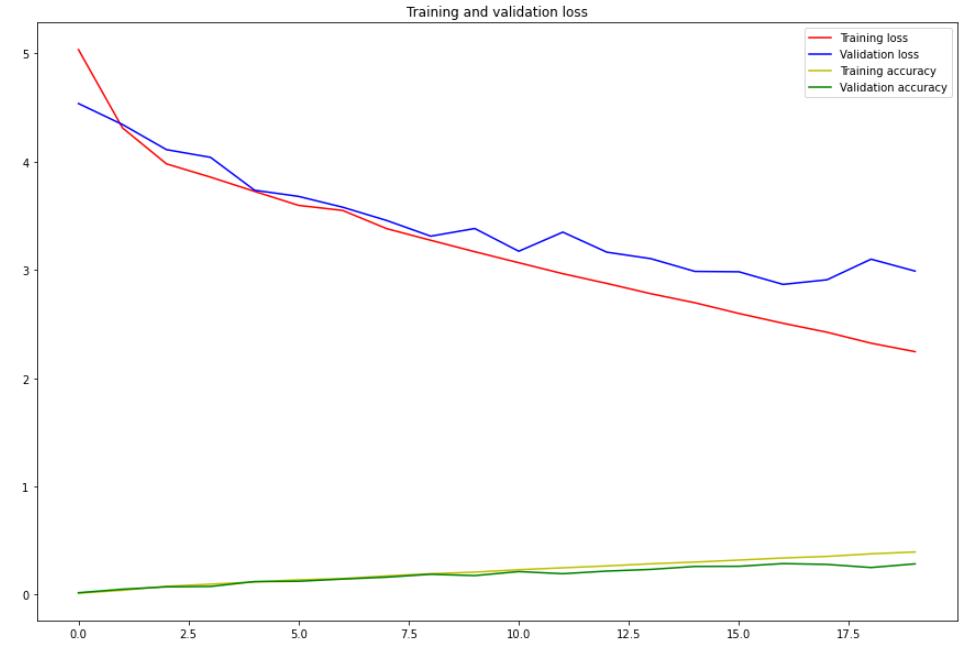

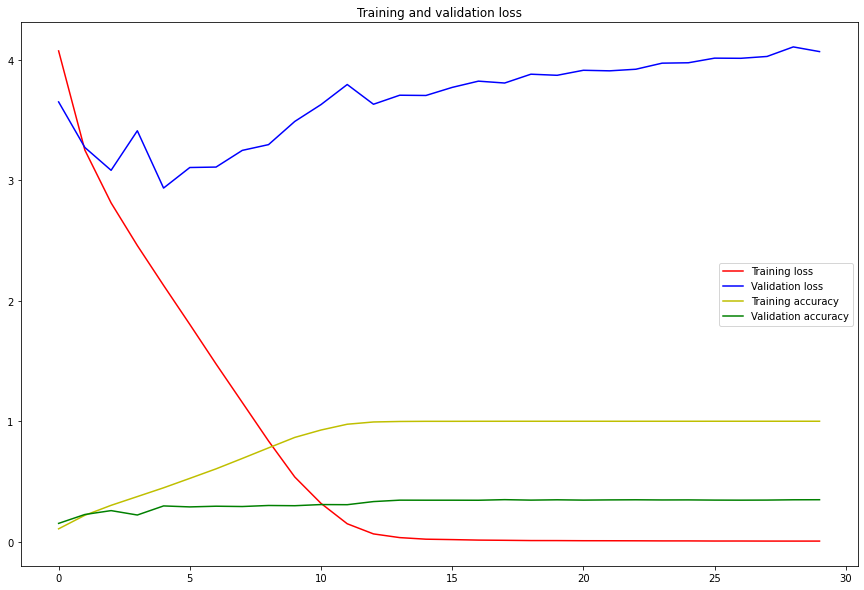

In [30]:
loss_preres = history_preres.history['loss']
val_loss_preres = history_preres.history['val_loss']
accuracy_preres = history_preres.history['accuracy']
val_accuracy_preres = history_preres.history['val_accuracy']

epochs = range(len(loss_preres))
plt.figure(figsize=(15,10))
plt.plot(epochs, loss_preres, 'r', label='Training loss')
plt.plot(epochs, val_loss_preres, 'b',label='Validation loss')
plt.plot(epochs, accuracy_preres, 'y',label='Training accuracy')
plt.plot(epochs, val_accuracy_preres, 'g',label='Validation accuracy')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
print("Fit model on test data")
test_loss_preres, test_acc_preres = preResnet_model.evaluate(x_test, y_test, verbose=1)
print(test_acc_preres)

Fit model on test data
10000/10000 [==============================] - 3s 257us/sample - loss: 4.0084 - accuracy: 0.3529
0.3529


- accuracy는 ADAM을 사용시 20epochs시 29%의 성능이 나온다. ResNet과 비교하면 약1%의 성능 향상이 있었다. 
- accuracy는 SGD를 사용시 20epochs시 37%의 성능이 나온다. ResNet과 비교하면 약1%의 성능 향상이 있었다. 
- accuracy는 SGD를 사용시 10epochs시 31%의 성능이 나온다. ResNet과 비교하면 약3%의 성능 저하가 있었다. 
- accuracy는 SGD를 사용시 30epochs시 35%의 성능이 나온다. ResNet과 비교하면 약2%의 성능 저하가 있었다. 

## VGG, Plain-34, Resnet, preactivation_Resnet validation accuracy 비교

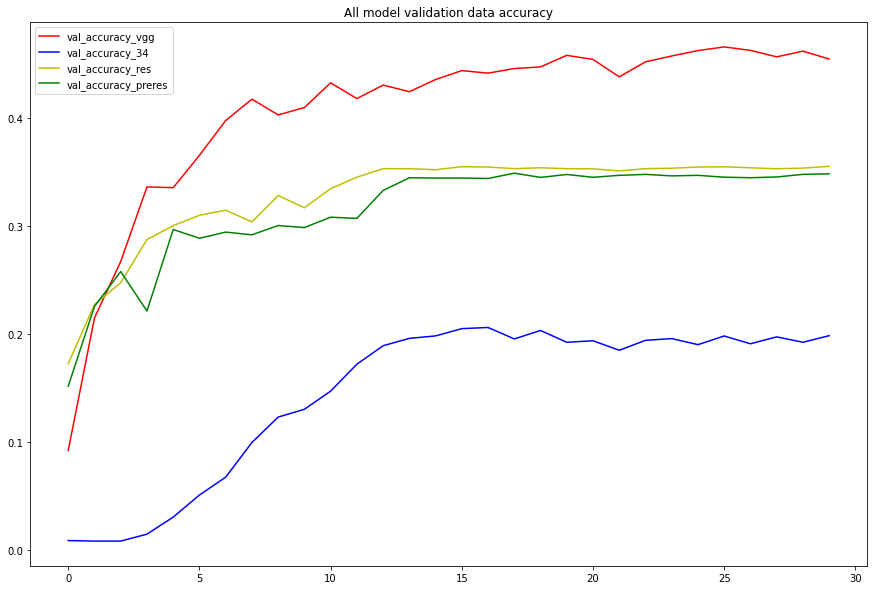

In [32]:
epochs = range(len(loss_preres))
plt.figure(figsize=(15,10))
plt.plot(epochs, val_accuracy_vgg, 'r', label='val_accuracy_vgg')
plt.plot(epochs, val_accuracy_34, 'b',label='val_accuracy_34')
plt.plot(epochs, val_accuracy_res, 'y',label='val_accuracy_res')
plt.plot(epochs, val_accuracy_preres, 'g',label='val_accuracy_preres')
plt.title('All model validation data accuracy')
plt.legend()

plt.show()

# VGG, Plain-34, Resnet, preactivation_Resnet validation loss 비교

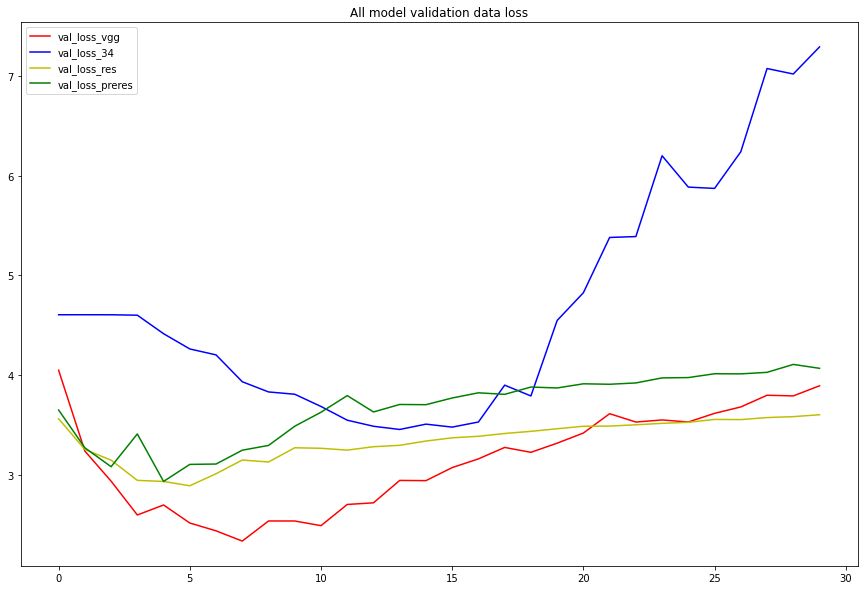

In [33]:
epochs = range(len(loss_preres))
plt.figure(figsize=(15,10))
plt.plot(epochs, val_loss_vgg, 'r', label='val_loss_vgg')
plt.plot(epochs, val_loss_34, 'b',label='val_loss_34')
plt.plot(epochs, val_loss_res, 'y',label='val_loss_res')
plt.plot(epochs, val_loss_preres, 'g',label='val_loss_preres')
plt.title('All model validation data loss')
plt.legend()

plt.show()

# VGG, Plain-34, Resnet, preactivation_Resnet test accuracy 비교

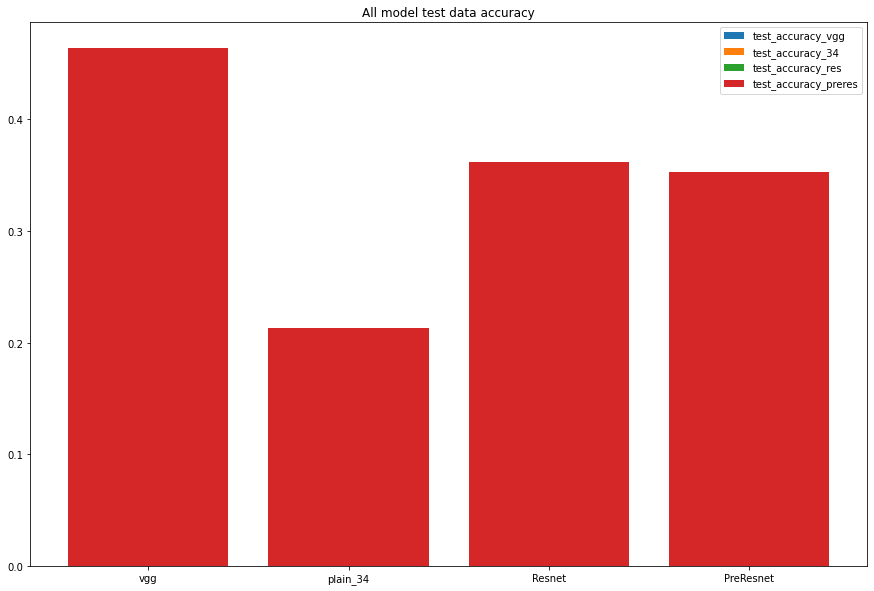

In [34]:
x = np.arange(4)
model = ['vgg', 'plain_34', 'Resnet', 'PreResnet']
value = [test_acc_vgg, test_acc_34, test_acc_res, test_acc_preres]
plt.figure(figsize=(15,10))
plt.bar(x, value, label='test_accuracy_vgg')
plt.bar(x, value, label='test_accuracy_34')
plt.bar(x, value, label='test_accuracy_res')
plt.bar(x, value, label='test_accuracy_preres')
plt.xticks(x, model)
plt.title('All model test data accuracy')
plt.legend()

plt.show()

# VGG, Plain-34, Resnet, preactivation_Resnet test loss 비교

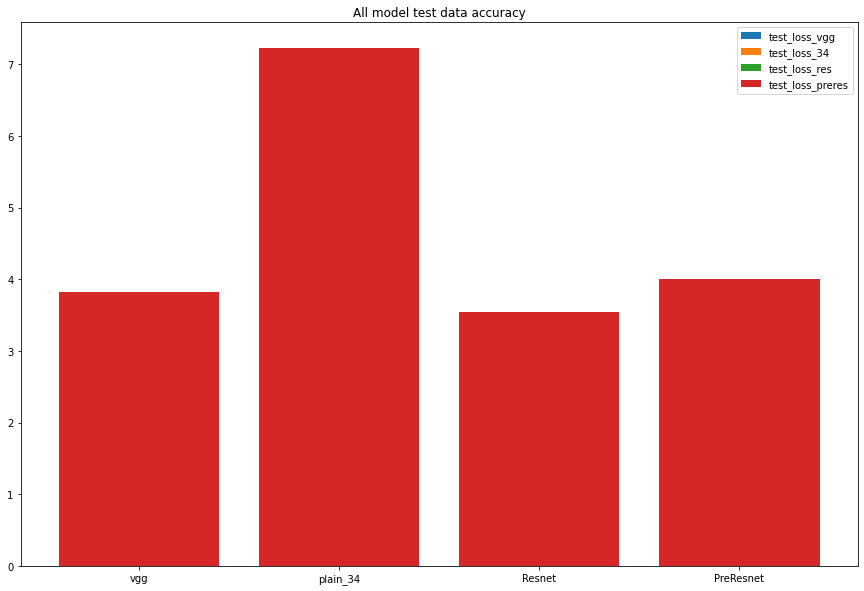

In [35]:
x = np.arange(4)
model = ['vgg', 'plain_34', 'Resnet', 'PreResnet']
value = [test_loss_vgg, test_loss_34, test_loss_res, test_loss_preres]
plt.figure(figsize=(15,10))
plt.bar(x, value, label='test_loss_vgg')
plt.bar(x, value, label='test_loss_34')
plt.bar(x, value, label='test_loss_res')
plt.bar(x, value, label='test_loss_preres')
plt.title('All model test data accuracy')
plt.xticks(x, model)
plt.legend()

plt.show()

- VGG는 데이터셋과 상관없이 깊게 만들어도 모델이 동작하였다.
- 하지만 plain_34와 Resnet, Pre-activation을 사용한 Resnet의 모델에서는 데이터셋이 작아지니 훈련이 진행되지 않았다.
- 그래서 VGG를 제외한 나머지의 모델을 경량화를 하였고
- Pre-activation_ResNet > ResNet > plain_34 순으로 성능이 나왔다. 
- Pre-activation을 사용하면 성능 향상을 볼수 있었다. 
- 그리고 ResNet의 skip-connection을 사용하니 기존의 plain모델보다 성능이 훨씬 좋아지는것을 알수 있었다.
- epochs를 적게 하면 학습이 덜되서 Test시 accuracy가 낮게 나오고
- epochs를 많이 하면 오버피팅이 발생하여 Test시 accuracy가 낮게 나온다.
- 최적의 accuracy를 찾기위해 최적의 epochs를 찾는것이 중요하다. 여기서는 20epochs가 가장 나은것을 알수있다.